## Описание эксперимента

Для Авито важно, чтобы пользователи проходили врификацию аккаунтов.

Существует инструмент мотивации - верифицированные аккаунты помечаются специальным значком в профиле и объявлении.

В эксперименте тестировались новые способы мотивации пользователей пройти верификацию. Дата начала эксперимента = 2021-09-15.

Пользователи были разделены на 3 группы. Первой группе приходила рассылка  о том, что если они верифицируют аккаунт - они получат значок, который привлекает внимание покупателей и приносит заказы (уже имеющийся функционал), двум другим приходила рассылка о том, что за верификацию кроме значка они получат также временную скидку на услуги на 30% и 60% соответственно.

Основная <b>идея эксперимента</b>, которую хотим проверить: продавцы будут охотнее верифицировать свой аккаунт, если выдавать им скидку на услуги Авито за прохождение верификации. 

## Гипотезы

Определим продуктовые гипотезы, которые хотим проверить этим экспериментом.

1. Для групп, получающих скидку, конверсия из получения рассылки в прохождение верификации больше, чем для группы без скидки
2. Для группы, получающей скидку 60%, конверсия из получения рассылки в прохождение верификации больше, чем для группы, получающей скидку 30%
3. Доход с одного пользователя(от покупки услуг) для групп, получающих скидку, больше, чем для группы без скидки
4. Для группы, получающей скидку 30%, доход с одного пользователя больше, чем для группы, получающей скидку 60%
5. Кол-во транзакций пользователя для групп, получающих скидку, больше, чем для группы без скидки
6. Для группы, получающей скидку 30%, кол-во транзакций пользователя меньше, чем для группы, получающей скидку 60%

Более формально, в каждом из пунктов ставится нулевая гипотеза о равенстве соответствующей метрики в подгруппах и альтернатива, описанная в продуктовой гипотезе.

## Выводы по результатам эксперимента

Здесь для удобства вынесены общие выводы, полученные после анализа эксперимента. Процесс самого анализа описан в следующих пунктах.

<b>Формально:</b>

Для пунктов 1 и 2 нулевые гипотезы отверглись.

Для пунктов 3-6 не можем отвергнуть нулевую гипотезу о равенстве на уровне значимости 5%.

<b>С точки зрения бизнеса:</b>

Группа со скидкой 30% оказалась неудачной, конверсия в ней меньше, чем для группы со скидкой 60%, при этом выручка и число транзакций тоже меньше, но не статистически значимо.

Группа со скидкой 60% немного просаживает метрики выручки и числа транзакций по сравнению с группой без скидки, но опять же не стат. значимо. Зато стат. значимо поднимает конверсию в верификацию.

Таким образом, идею выдавать временную скидку в 60% за прохождение верификации можно считать удачной.

## Техническая часть
Импорт необходимых библиотек и подключение к базе

In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import datetime
from scipy.stats import binomtest, multinomial
import numpy as np
import math
import seaborn as sns
import json
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

In [2]:
with open('credentials.json', 'r') as json_file:
    credentials = json.load(json_file)

connection = psycopg2.connect(database="postgres",
                              user=credentials.get('user'),
                              password=credentials.get('password'),
                              host=credentials.get('host'),
                              port=credentials.get('port'))
cursor = connection.cursor()

In [3]:
START_DATE = datetime.datetime.strptime('2021-09-15', "%Y-%m-%d").date()

Выгрузка данных

In [4]:
sql1 = "SELECT * from PUBLIC.services_verification_experiment_segment"
groups = sqlio.read_sql_query(sql1, connection)
groups['RegistrationTime'] = groups['RegistrationTime'].apply(lambda x: x.date())

C:\Users\liza-\AppData\Local\Temp\ipykernel_3540\3448827113.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  groups = sqlio.read_sql_query(sql1, connection)


In [5]:
sql2 = f"""
    SELECT user_id, item_region, count(item_id) as item_count
    FROM PUBLIC.user_item_info
    WHERE item_creation_time < '{START_DATE}'
    GROUP BY user_id, item_region
"""
items_before = sqlio.read_sql_query(sql2, connection)

C:\Users\liza-\AppData\Local\Temp\ipykernel_3540\3588913436.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  items_before = sqlio.read_sql_query(sql2, connection)


In [6]:
sql3 = f"""
    SELECT user_id, item_region, count(item_id) as item_count
    FROM PUBLIC.user_item_info
    WHERE item_creation_time >= '{START_DATE}'
    GROUP BY user_id, item_region
"""
items_after = sqlio.read_sql_query(sql3, connection)

C:\Users\liza-\AppData\Local\Temp\ipykernel_3540\2188067215.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  items_after = sqlio.read_sql_query(sql3, connection)


In [7]:
sql4 = """
    SELECT user_id, max(discount_day) as verification_day
    FROM PUBLIC.services_verification_discounts
    GROUP BY user_id
"""
verifications = sqlio.read_sql_query(sql4, connection)

C:\Users\liza-\AppData\Local\Temp\ipykernel_3540\2996437178.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  verifications = sqlio.read_sql_query(sql4, connection)


In [8]:
sql5 = f"""
    SELECT *
    FROM PUBLIC.user_payments_info
    WHERE event_time >= '{START_DATE}'
"""
payments_after = sqlio.read_sql_query(sql5, connection)

sql6 = f"""
    SELECT *
    FROM PUBLIC.user_payments_info
    WHERE event_time < '{START_DATE}'
"""
payments_before = sqlio.read_sql_query(sql6, connection)

C:\Users\liza-\AppData\Local\Temp\ipykernel_3540\354401185.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  payments_after = sqlio.read_sql_query(sql5, connection)
C:\Users\liza-\AppData\Local\Temp\ipykernel_3540\354401185.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  payments_before = sqlio.read_sql_query(sql6, connection)


## Данные

Распределение пользователей по группам

In [9]:
groups.head()

,user_id,experiment_group,UserType,RegistrationTime
0,379831899,no_discount,Private,2011-09-29
1,379840344,no_discount,Private,2010-12-13
2,379840883,no_discount,Private,2012-06-12
3,379843930,30_discount,Company,2011-01-11
4,379856281,60_discount,Private,2012-10-02


Статистика объявлений для пользователей (польователь, регион, кол-во объявлений) за период до начала эксперимента. 

In [10]:
items_before.head()

,user_id,item_region,item_count
0,1,39,242
1,1,75,218
2,16,25,39
3,101,18,1
4,101,19,1


Статистика объявлений для пользователей после начала эксперимента.

In [11]:
items_after.head()

,user_id,item_region,item_count
0,1,39,43
1,16,25,3
2,101,28,1
3,101,41,1
4,101,42,1


Информация о дате верификации аккаунта

In [12]:
verifications.head()

,user_id,verification_day
0,350226250002,2021-09-30
1,786028000097,2021-09-19
2,248318750121,2021-09-22
3,151512500036,2021-09-17
4,1770870,2021-09-17


Транзакции покупки услуг пользоветлями до и после начала эксперимента

In [13]:
payments_before.head()

,user_id,item_id,event_time,transaction_type,transaction_subtype,amount_net
0,11015250077,1.122795e+12,2021-09-12 20:23:30,4,3,22.153846
1,144027250025,1.122799e+12,2021-09-12 18:27:55,4,3,55.692308
2,371165296,1.122822e+12,2021-09-12 19:19:56,4,3,23.307692
3,1599254,1.122825e+12,2021-09-12 18:48:17,4,3,20.769231
4,525663250063,1.122836e+12,2021-09-12 19:44:44,4,3,27.384615


In [14]:
payments_after.head()

,user_id,item_id,event_time,transaction_type,transaction_subtype,amount_net
0,372833007,1.123248e+12,2021-09-15 11:14:22,4,3,19.153846
1,461930000048,1.123269e+12,2021-09-19 15:12:39,4,3,37.769231
2,805185000028,1.123294e+12,2021-09-24 11:16:41,4,3,19.153846
3,842192500175,1.123334e+12,2021-09-17 15:48:46,4,3,57.615385
4,344087500599,1.123502e+12,2021-09-17 17:37:47,4,3,63.692308


## Исследование данных
Посмотрим на равномерность распределения пользователей на экспериментальные группы в разных разрезах.

Объединим данные

In [15]:
verifications = pd.merge(groups, verifications, how='left')
verifications.head()

,user_id,experiment_group,UserType,RegistrationTime,verification_day
0,379831899,no_discount,Private,2011-09-29,NaN
1,379840344,no_discount,Private,2010-12-13,NaN
2,379840883,no_discount,Private,2012-06-12,NaN
3,379843930,30_discount,Company,2011-01-11,NaN
4,379856281,60_discount,Private,2012-10-02,2021-10-10


In [16]:
data = pd.merge(groups, items_before)
data.head()

,user_id,experiment_group,UserType,RegistrationTime,item_region,item_count
0,379831899,no_discount,Private,2011-09-29,15,81
1,379831899,no_discount,Private,2011-09-29,17,25
2,379831899,no_discount,Private,2011-09-29,25,23
3,379831899,no_discount,Private,2011-09-29,56,1
4,379831899,no_discount,Private,2011-09-29,62,1


Для начала, надо проверить что каждый пользователь находится только в 1 группе теста.

In [17]:
groups.groupby(by=['user_id'])[["user_id", "experiment_group"]].filter(lambda x: len(x) > 1)

,user_id,experiment_group


Все в порядке.

#### По типу пользователя

In [18]:
groups_by_types = data.groupby(by=['experiment_group', 'UserType'])[["user_id"]].nunique().unstack(level=0)

<Axes: xlabel='UserType'>

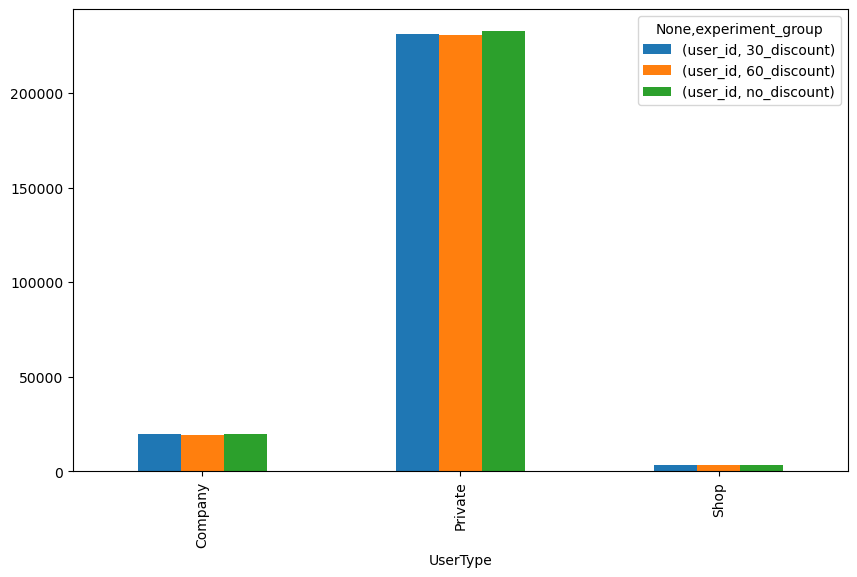

In [19]:
groups_by_types.plot.bar(figsize=(10, 6))

Визуально кажется, что в каждой эксперименальной группе равное число пользователй каждого типа.

Проверим с помощью биномильаного теста.
Посчитаем суммарное кол-во пользователей без скидки в разных группах и общее кол-во в группе $n$. Проверим, насколько вероятно, что такое распределение могло получиться из биномиального распределения $Bin(n, p)$, где $p=\frac{1}{3}$.

In [20]:
groups_by_types['sum'] = (groups_by_types['user_id']['30_discount']
                          + groups_by_types['user_id']['60_discount']
                          + groups_by_types['user_id']['no_discount'])
groups_by_types['pvalue'] = list(map(lambda x,y: binomtest(x, n=y, p=1/3).pvalue,
                                     groups_by_types['user_id']['no_discount'],
                                     groups_by_types['sum']))
groups_by_types.sort_values('pvalue').style.applymap(lambda x: f"background-color: {'orange' if x < 0.05 else None}",
                                                     subset=pd.IndexSlice[:, ['pvalue']])

Биномиальный тест показывает, что для типов пользователей Private и Company распределение по группам неравномерное.

#### По региону пользователя

Проведем такой же анализ в разрезе региона размещения объяявления.

In [21]:
groups_by_region = data.groupby(by=['item_region', 'experiment_group'])[["user_id"]].nunique().unstack(level=1)
groups_by_region['sum'] = (groups_by_region['user_id']['30_discount']
                           + groups_by_region['user_id']['60_discount']
                           + groups_by_region['user_id']['no_discount'])

In [22]:
groups_by_region['pvalue'] = list(map(lambda x,y: binomtest(x, n=y, p=1/3).pvalue,
                                      groups_by_region['user_id']['no_discount'],
                                      groups_by_region['sum']))
groups_by_region.sort_values('pvalue').style.applymap(lambda x: f"background-color: {'orange' if x < 0.05 else None}",
                                                      subset=pd.IndexSlice[:, ['pvalue']])

Внутри почти всех регионов распределение равномерное.

#### По количеству

In [23]:
groups_sizes = groups.groupby(by=['experiment_group'])[["user_id"]].nunique()
groups_sizes

,user_id
experiment_group,
30_discount,253663
60_discount,253441
no_discount,255626


Визуально разница незаметна.

Построим критерий для определения, могли полученные значения быть из полиномиального распределения.

Введем статистику $Q(x) = max(x) - min(x)$. Посмотрим как она выглядит при верной нулевой гипотезе. То есть, когда общее число элементов такое же, как в нашем случае $n = 253663+253441+255626$, а вероятности попадания в каждый из классов равны $\frac{1}{3}$.

In [24]:
def get_q_stat(x):            
    return max(x) - min(x)

n = sum(groups_sizes.user_id)

np.random.seed(42)
n_samples = 100000

p_H0 = np.array([1/3, 1/3, 1/3])

how_q_statistics_look_like_when_H0 = []
for i in range(n_samples):
    x = multinomial.rvs(n=n, p=p_H0)
    how_q_statistics_look_like_when_H0.append(get_q_stat(x))

<Axes: ylabel='Count'>

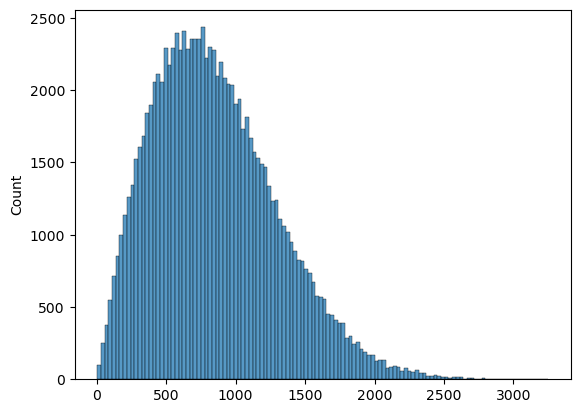

In [25]:
sns.histplot(how_q_statistics_look_like_when_H0)

Определим по этому эмпирическому распределению границу отвержения, то есть 95ю квантиль.

In [26]:
critical_value = sorted(how_q_statistics_look_like_when_H0)[math.floor(n_samples * 0.95 - 1)] + 1
critical_value

1671

С помощью МК проверм, что полученный критерий работает. То есть ошибка первого рода не превосходит 0.05

In [27]:
np.random.seed(42)
false_positives = 0
true_negatives = 0

q_statistics = []
for i in range(n_samples):
    x = multinomial.rvs(n=n, p=p_H0)
    q = get_q_stat(x)
    
    if q >= critical_value:
        false_positives += 1
    else:
        true_negatives += 1
        
print(f'alpha is {false_positives / (false_positives + true_negatives):.3f}')

alpha is 0.050


Все в порядке. Посмотрим также на мощность.

In [28]:
np.random.seed(42)
true_positives = 0
false_negatives = 0

for i in range(n_samples):
    shift = [0.001, -0.001, 0]
    np.random.shuffle(shift)
    p_H1 = p_H0 = np.array([1/3, 1/3, 1/3]) - shift
    
    x = multinomial.rvs(n=n, p=p_H1)
    q = get_q_stat(x)
    if q >= critical_value:
        true_positives += 1
    else:
        false_negatives += 1
    
print(f'power is {true_positives / (true_positives + false_negatives):.3f}')

power is 0.469


Применим полученный критерий к наему случаю.

In [29]:
get_q_stat(groups_sizes.user_id), critical_value

(2185, 1671)

In [30]:
get_q_stat(groups_sizes.user_id) > critical_value

True

Критерий отвергает гипотезу о том, что люди в группах распределены равномерно по кол-ву.

### AA тесты

Проверим гипотезы 3-6 на данных до теста. Гипотезы 1 и 2 проверить не можем, так как нет данных о прохождении верификаций до даты начала эксперимента.

In [31]:
# аггрегация данных
payments_agg = payments_before.merge(groups, on='user_id', how='right')[['user_id', 'amount_net', 'experiment_group']]

payments_agg = payments_agg.groupby(['user_id', 'experiment_group']).agg({'amount_net': ['sum', 'count']})

payments_agg = payments_agg.reset_index('experiment_group')

payments_agg.columns = ['experiment_group', 'p_sum', 'p_count']

In [32]:
payments_agg.head()

,experiment_group,p_sum,p_count
user_id,,,
1,60_discount,0.000000,0
16,no_discount,0.000000,0
101,no_discount,384.769231,14
128,no_discount,0.000000,0
173,no_discount,20.230769,1


Поллучили кол-во и сумму транзакций по каждому пользователю. Поделим на экспериментальные группы. Выделяем группу со скидкй 30, со скидкой 60, без скидки и с любой скидкой.

С помощью t-test проверяем равенство среднего по пользователям значения суммы и кол-ва покупок в разных группах в соответствии с гипотезами. Нужно так же учесть поправку на множественную проверку гипотез.

In [33]:
group_no = payments_agg[payments_agg['experiment_group'] == 'no_discount']
group_disc = payments_agg[payments_agg['experiment_group'] != 'no_discount']
group_30 = payments_agg[payments_agg['experiment_group'] == '30_discount']
group_60 = payments_agg[payments_agg['experiment_group'] == '60_discount']

In [34]:
p_values = []
p_values.append(ttest_ind(group_no['p_sum'], group_disc['p_sum'])[1])     # H3
p_values.append(ttest_ind(group_no['p_count'], group_disc['p_count'])[1]) # H4
p_values.append(ttest_ind(group_30['p_sum'], group_60['p_sum'])[1])       # H5
p_values.append(ttest_ind(group_30['p_count'], group_60['p_count'])[1])   # H6

In [35]:
p_values

[0.1860901484918118,
 0.17043593143896713,
 0.2467690418035864,
 0.1314000624902599]

In [36]:
reject, p_corrected, _, _ = multipletests(np.sort(p_values), alpha=0.05, method='holm')
# выдает для каждой гипотезы H0_i, нужно ли ее _отклонить_

print(reject, p_corrected)

[False False False False] [0.52560025 0.52560025 0.52560025 0.52560025]


### Вывод по АА тестам:

На АА тесте не отвергаются нулевые гипотезы для пунтктов 3-6, то есть средняя сумма и кол-во покупок совпадают для разных групп до начала эксперимента.

### AВ тесты

Теперь проведем аналогичные действия, но уже на данных после начала эксперимента.

In [37]:
payments_agg = payments_after.merge(groups, on='user_id', how='right')[['user_id', 'amount_net', 'experiment_group']]

payments_agg = payments_agg.groupby(['user_id', 'experiment_group']).agg({'amount_net': ['sum', 'count']})

payments_agg = payments_agg.reset_index('experiment_group')

payments_agg.columns = ['experiment_group', 'p_sum', 'p_count']

In [38]:
group_no = payments_agg[payments_agg['experiment_group'] == 'no_discount']
group_disc = payments_agg[payments_agg['experiment_group'] != 'no_discount']
group_30 = payments_agg[payments_agg['experiment_group'] == '30_discount']
group_60 = payments_agg[payments_agg['experiment_group'] == '60_discount']

In [39]:
p_values = []
p_values.append(ttest_ind(group_no['p_sum'], group_disc['p_sum'])[1])     # H3
p_values.append(ttest_ind(group_no['p_count'], group_disc['p_count'])[1]) # H4
p_values.append(ttest_ind(group_30['p_sum'], group_60['p_sum'])[1])       # H5
p_values.append(ttest_ind(group_30['p_count'], group_60['p_count'])[1])   # H6

In [40]:
sum(group_60['p_sum']) - sum(group_30['p_sum'])

1365268.163077563

In [41]:
sum(group_60['p_count']) - sum(group_30['p_count'])

99423

In [42]:
sum(group_60['p_sum']) - sum(group_no['p_sum'])

-1936174.4230767377

In [43]:
sum(group_60['p_count']) - sum(group_no['p_count'])

-82505

In [44]:
p_values

[0.103257483771887,
 0.10862601834711179,
 0.2588790563345431,
 0.10772285271354612]

In [45]:
reject, p_corrected, _, _ = multipletests(np.sort(p_values), alpha=0.05, method='holm')
# выдает для каждой гипотезы H0_i, нужно ли ее _отклонить_

print(reject, p_corrected)

[False False False False] [0.41302994 0.41302994 0.41302994 0.41302994]


Получаем, что для группы со скидкой 60% и кол-во покупок и сумма больше, чем для группы со скидкой 30%, но меньше, чем для группы вообще без скидок. Но это изменение статистически не значимо, так как гипотезы о равенстве не отверглись.

Посмотрим теперь на верификации (гипотеза 1 и 2)

In [46]:
verifications['is_verified'] = 1 - verifications['verification_day'].isna()

In [47]:
group_no = verifications[verifications['experiment_group'] == 'no_discount']
group_disc = verifications[verifications['experiment_group'] != 'no_discount']
group_30 = verifications[verifications['experiment_group'] == '30_discount']
group_60 = verifications[verifications['experiment_group'] == '60_discount']

In [48]:
p_values = []
p_values.append(ttest_ind(group_disc['is_verified'], group_no['is_verified'], alternative='greater')[1]) # H1
p_values.append(ttest_ind(group_60['is_verified'], group_30['is_verified'], alternative='greater')[1])   # H2

In [49]:
p_values

[8.068507848270672e-26, 8.773531211434318e-12]

In [50]:
reject, p_corrected, _, _ = multipletests(np.sort(p_values), alpha=0.05, method='holm')
# выдает для каждой гипотезы H0_i, нужно ли ее _отклонить_

print(reject, p_corrected)

[ True  True] [1.61370157e-25 8.77353121e-12]


Конверсия для групп со скидкой выросла.

Конверсия для группы со скидкой 60% больше, чем для группы со скидкой 30%.

Выручка и число транзакций значимо не поменялись.

### Вывод по АB тестам:

На АB тесте также не отвергаются нулевые гипотезы для пунтктов 3-6, хоть изменения есть, но они статистически не значимы на уровне значимости 5%.

При этом для гипотез 1 и 2 нулевые гипотезы отвергаются, то есть конверсия для групп со скидкой выросла, и конверсия для группы со скидкой 60% больше, чем для группы со скидкой 30%.

## Общий вывод

<b>Формально:</b>

Для пунктов 1 и 2 нулевые гипотезы отверглись.

Для пунктов 3-6 не можем отвергнуть нулевую гипотезу о равенстве на уровне значимости 5%.

<b>С точки зрения бизнеса:</b>

Группа со скидкой 30% оказалась неудачной, конверсия в ней меньше, чем для группы со скидкой 60%, при этом выручка и число транзакций тоже меньше, но не статистически значимо.

Группа со скидкой 60% немного просаживает метрики выручки и числа транзакций по сравнению с группой без скидки, но опять же не стат. значимо. Зато стат. значимо поднимает конверсию в верификацию.

Таким образом, идею выдавать временную скидку в 60% за прохождение верификации можно считать удачной.